In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
import optuna
import xgboost as xgb
import shap
import torch
import torch.nn as nn
import torch.optim as optim

from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Configuration
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

print("--- Crop Yield Prediction Pipeline Initialized ---")


/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


--- Crop Yield Prediction Pipeline Initialized ---



# ==========================================
# 1. DATA LOADING & CONFIGURATION
# ==========================================


In [2]:

# Configuration Constants
TRAIN_END = 2007
VAL_END = 2010
LOOKBACK = 5
TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
BASE_NUMERIC_COLS = [
    'average_rain_fall_mm_per_year', 
    'pesticides_tonnes', 
    'avg_temp', 
    'fertilizer_kg/ha', 
    'solar_radiation_MJ/m2-day'
]

# Load Data
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Data loaded: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Error: 'cleaned_crop_data.csv' not found.")


Data loaded: (13130, 9)



# ==========================================
# 2. PREPROCESSING & FEATURE ENGINEERING
# ==========================================


In [3]:

print("\n--- Step 2: Preprocessing ---")

# 2.1 Split Data (Chronological)
train_df_orig = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_orig = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_orig = df[df[TIME_COL] > VAL_END].copy()

# 2.2 Label Encoding (Fit on Train, Apply to All)
# We keep these for Deep Learning Embeddings
le_area = LabelEncoder().fit(train_df_orig['Area'])
le_item = LabelEncoder().fit(train_df_orig['Item'])

for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['Area_Encoded'] = d['Area'].apply(lambda x: le_area.transform([x])[0] if x in le_area.classes_ else 0)
    d['Item_Encoded'] = d['Item'].apply(lambda x: le_item.transform([x])[0] if x in le_item.classes_ else 0)

# 2.3 Detrending (Remove Global/Local Trends)
print("Fitting trend models...")
trend_models = {}
global_trend_model = LinearRegression().fit(train_df_orig[[TIME_COL]], train_df_orig[TARGET])

for group, group_df in train_df_orig.groupby(CAT_COLS):
    if len(group_df) > 1:
        model = LinearRegression().fit(group_df[[TIME_COL]], group_df[TARGET])
        trend_models[group] = model

for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['yield_trend'] = 0.0
    for group, group_df in d.groupby(CAT_COLS):
        model = trend_models.get(group, global_trend_model)
        d.loc[group_df.index, 'yield_trend'] = model.predict(group_df[[TIME_COL]])
    d['yield_detrended'] = d[TARGET] - d['yield_trend']

# 2.4 Feature Lagging
# We create lags for everything, but we will DROP the target lags later for ML models
full_df = pd.concat([train_df_orig, val_df_orig, test_df_orig]).sort_values(CAT_COLS + [TIME_COL])
cols_to_lag = ['yield_detrended'] + BASE_NUMERIC_COLS

for col in cols_to_lag:
    for lag in [1, 2]:
        full_df[f'{col}_lag{lag}'] = full_df.groupby(CAT_COLS)[col].shift(lag)

full_df = full_df.dropna()

# Re-split after lagging
train_df = full_df[full_df[TIME_COL] <= TRAIN_END].copy()
val_df = full_df[(full_df[TIME_COL] > TRAIN_END) & (full_df[TIME_COL] <= VAL_END)].copy()
test_df = full_df[full_df[TIME_COL] > VAL_END].copy()

# 2.5 Scaling
feature_cols = [c for c in train_df.columns if c in BASE_NUMERIC_COLS or '_lag' in c]
# IMPORTANT: Exclude the target lag columns from the "feature_cols" list we use for scaling 
# if we plan to drop them. For now, we scale everything, then drop later.
x_scaler = StandardScaler()
y_scaler = StandardScaler()

train_df[feature_cols] = x_scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = x_scaler.transform(val_df[feature_cols])
test_df[feature_cols] = x_scaler.transform(test_df[feature_cols])

train_df['yield_detrended'] = y_scaler.fit_transform(train_df[['yield_detrended']])
val_df['yield_detrended'] = y_scaler.transform(val_df[['yield_detrended']])
test_df['yield_detrended'] = y_scaler.transform(test_df[['yield_detrended']])

print("Preprocessing complete. Transformers fitted.")




--- Step 2: Preprocessing ---
Fitting trend models...
Preprocessing complete. Transformers fitted.



# ==========================================
# 3. ML SPECIFIC PREPARATION (The Fixes)
# ==========================================


In [4]:

print("\n--- Step 3: ML Data Preparation (Fixing Overfitting) ---")

# 3.1 Select Features
# We initially take all numeric columns + encoded IDs
ml_cols = feature_cols + ['Area_Encoded', 'Item_Encoded']

X_train_ml = train_df[ml_cols].copy()
y_train_ml = train_df['yield_detrended']
X_val_ml = val_df[ml_cols].copy()
y_val_ml = val_df['yield_detrended']
X_test_ml = test_df[ml_cols].copy()
y_test_ml = test_df['yield_detrended']

# 3.2 FIX 1: Drop Target Lags (Prevent Leakage)
# We force the model to learn from Weather/Soil, not just yesterday's yield.
drop_cols = ['yield_detrended_lag1', 'yield_detrended_lag2']
X_train_ml = X_train_ml.drop(columns=drop_cols, errors='ignore')
X_val_ml = X_val_ml.drop(columns=drop_cols, errors='ignore')
X_test_ml = X_test_ml.drop(columns=drop_cols, errors='ignore')
print(f"Dropped leakage columns: {drop_cols}")

# 3.3 FIX 2: Target Encoding (Help Trees understand Country/Crop)
# Replace Arbitrary IDs (1, 2, 3) with Mean Yield (5000, 3000, 8000)
print("Applying Target Encoding...")

# Calculate means on TRAIN ONLY
temp_train = X_train_ml.copy()
temp_train['target'] = y_train_ml

area_means = temp_train.groupby('Area_Encoded')['target'].mean()
item_means = temp_train.groupby('Item_Encoded')['target'].mean()
global_mean = y_train_ml.mean()

# Map to all sets
for df_ml in [X_train_ml, X_val_ml, X_test_ml]:
    df_ml['Area_Target_Mean'] = df_ml['Area_Encoded'].map(area_means).fillna(global_mean)
    df_ml['Item_Target_Mean'] = df_ml['Item_Encoded'].map(item_means).fillna(global_mean)
    # Drop the old IDs (Trees don't need them now)
    df_ml.drop(columns=['Area_Encoded', 'Item_Encoded'], inplace=True)

print(f"ML Features Finalized: {X_train_ml.shape[1]} features.")




--- Step 3: ML Data Preparation (Fixing Overfitting) ---
Dropped leakage columns: ['yield_detrended_lag1', 'yield_detrended_lag2']
Applying Target Encoding...
ML Features Finalized: 17 features.



# ==========================================
# 4. DL SPECIFIC PREPARATION
# ==========================================


In [5]:
print("\n--- Step 4: Deep Learning Data Preparation ---")

# Define Features for DL (Must exclude the dropped lags to match consistency)
# We take the columns remaining in X_train_ml, but distinct strictly between numeric vs categorical
dl_numeric_features = [c for c in X_train_ml.columns if c not in ['Area_Target_Mean', 'Item_Target_Mean']]
print(f"DL Numeric Features ({len(dl_numeric_features)}): {dl_numeric_features}")

# --- FIX 3: EXTEND DATASETS TO FIX VALIDATION CRASH ---
# Concatenates the tail of the previous dataset to allow sequence generation
def extend_dataset(prev_df, curr_df, lookback, cat_cols):
    tails = prev_df.groupby(cat_cols).tail(lookback - 1)
    return pd.concat([tails, curr_df]).sort_values(cat_cols + [TIME_COL])

# Create Extended Dataframes
val_df_ext = extend_dataset(train_df, val_df, LOOKBACK, CAT_COLS)
test_df_ext = extend_dataset(val_df, test_df, LOOKBACK, CAT_COLS)

def create_sequences(data, lookback, num_feats, target_col):
    """Creates sequences compatible with the ML feature set + Embeddings"""
    X_num, X_cat, y = [], [], []
    y_indices = []
    
    # Note: data is the scaled dataframe (train_df, etc.)
    # We need to grab the Area/Item Encoded columns from it (they are still there)
    
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback: continue
        
        # Numeric features (Weather, Soil, etc.)
        gf_num = group[num_feats].values
        # Categorical features (Area, Item) - Static for the group
        gf_area = group['Area_Encoded'].values[0]
        gf_item = group['Item_Encoded'].values[0]
        gt = group[target_col].values
        indices = group.index
        
        for i in range(len(group) - lookback + 1):
            X_num.append(gf_num[i:i+lookback])
            X_cat.append([gf_area, gf_item]) # Store as pair
            y.append(gt[i+lookback-1])
            y_indices.append(indices[i+lookback-1])
            
    return np.array(X_num), np.array(X_cat), np.array(y), np.array(y_indices)

# Generate Sequences using EXTENDED Dataframes
X_train_seq_n, X_train_seq_c, y_train_seq, _ = create_sequences(train_df, LOOKBACK, dl_numeric_features, 'yield_detrended')
# Use extended DFs for Val/Test
X_val_seq_n, X_val_seq_c, y_val_seq, _ = create_sequences(val_df_ext, LOOKBACK, dl_numeric_features, 'yield_detrended')
X_test_seq_n, X_test_seq_c, y_test_seq, y_test_idx = create_sequences(test_df_ext, LOOKBACK, dl_numeric_features, 'yield_detrended')

# Helper to wrap into Tensors (With Safety Check for Empty Arrays)
def to_tensors(X_n, X_c, y):
    if len(X_n) == 0:
        # Return empty tensors with correct dimensions to avoid crashing
        return [
            torch.empty(0, LOOKBACK, X_n.shape[-1] if len(X_n.shape) > 2 else len(dl_numeric_features)),
            torch.empty(0, dtype=torch.long),
            torch.empty(0, dtype=torch.long),
        ], torch.empty(0, 1)

    return [
        torch.tensor(X_n, dtype=torch.float32),
        torch.tensor(X_c[:, 0], dtype=torch.long), # Area
        torch.tensor(X_c[:, 1], dtype=torch.long), # Item
    ], torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_train_dl, y_train_t = to_tensors(X_train_seq_n, X_train_seq_c, y_train_seq)
X_val_dl, y_val_t = to_tensors(X_val_seq_n, X_val_seq_c, y_val_seq)
X_test_dl, y_test_t = to_tensors(X_test_seq_n, X_test_seq_c, y_test_seq)

# Reference DF for Test Evaluation (Using indices from Sequence Generation)
test_df_dl_ref = test_df_ext.loc[y_test_idx].copy()

print(f"DL Train Seq Shape: {X_train_dl[0].shape}")
print(f"DL Val Seq Shape:   {X_val_dl[0].shape}")
print(f"DL Test Seq Shape:  {X_test_dl[0].shape}")



--- Step 4: Deep Learning Data Preparation ---
DL Numeric Features (15): ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day', 'average_rain_fall_mm_per_year_lag1', 'average_rain_fall_mm_per_year_lag2', 'pesticides_tonnes_lag1', 'pesticides_tonnes_lag2', 'avg_temp_lag1', 'avg_temp_lag2', 'fertilizer_kg/ha_lag1', 'fertilizer_kg/ha_lag2', 'solar_radiation_MJ/m2-day_lag1', 'solar_radiation_MJ/m2-day_lag2']
DL Train Seq Shape: torch.Size([6117, 5, 15])
DL Val Seq Shape:   torch.Size([1725, 5, 15])
DL Test Seq Shape:  torch.Size([1163, 5, 15])



# ==========================================
# 5. MODEL DEFINITIONS (REGULARIZED)
# ==========================================


In [6]:

# 5.1 Ridge Regression
def objective_lr(trial):
    alpha = trial.suggest_float('alpha', 0.1, 20.0, log=True)
    model = Ridge(alpha=alpha)
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_val_ml)
    return np.sqrt(mean_squared_error(y_val_ml, preds))

# 5.2 Random Forest
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 10),        
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20), 
        'max_features': trial.suggest_float('max_features', 0.4, 0.8)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train_ml, y_train_ml)
    return np.sqrt(mean_squared_error(y_val_ml, model.predict(X_val_ml)))

# 5.3 XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 30), 
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
    }
    model = xgb.XGBRegressor(random_state=42, early_stopping_rounds=50, eval_metric='rmse', **params)
    model.fit(X_train_ml, y_train_ml, eval_set=[(X_val_ml, y_val_ml)], verbose=False)
    return np.sqrt(mean_squared_error(y_val_ml, model.predict(X_val_ml)))

# 5.4 Deep Learning Models (Fixed Forward Pass)
class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, input_dim, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(input_dim + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
        
    def forward(self, num, area, item):
        # FIX: Expand static embeddings to match sequence length (Batch, Seq, Embed)
        seq_len = num.size(1)
        emb_area = self.embed_area(area).unsqueeze(1).expand(-1, seq_len, -1)
        emb_item = self.embed_item(item).unsqueeze(1).expand(-1, seq_len, -1)
        
        # Now they are all 3D: (B, L, Features)
        x = torch.cat([num, emb_area, emb_item], dim=-1)
        
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1])
        return self.fc2(torch.relu(self.fc1(out)))

class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, input_dim, filters, kernel, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.conv = nn.Conv1d(input_dim + 10 + 5, filters, kernel)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(filters, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
        
    def forward(self, num, area, item):
        # FIX: Expand static embeddings to match sequence length
        seq_len = num.size(1)
        emb_area = self.embed_area(area).unsqueeze(1).expand(-1, seq_len, -1)
        emb_item = self.embed_item(item).unsqueeze(1).expand(-1, seq_len, -1)
        
        # Concatenate (B, L, F) -> Transpose to (B, F, L) for Conv1d
        x = torch.cat([num, emb_area, emb_item], dim=-1).transpose(1, 2)
        
        x = self.pool(torch.relu(self.conv(x))).squeeze(-1)
        return self.fc2(torch.relu(self.fc1(self.drop(x))))

def train_dl(model, opt, loader, val_loader, epochs=100, patience=15):
    scheduler = ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    best_rmse = float('inf')
    wait = 0
    loss_fn = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        for x1, x2, x3, y in loader:
            x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
            opt.zero_grad()
            loss_fn(model(x1, x2, x3), y).backward()
            opt.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x1, x2, x3, y in val_loader:
                x1, x2, x3, y = x1.to(device), x2.to(device), x3.to(device), y.to(device)
                val_loss += loss_fn(model(x1, x2, x3), y).item()
        
        val_rmse = np.sqrt(val_loss / len(val_loader))
        scheduler.step(val_rmse)
        
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            wait = 0
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}.pth')
        else:
            wait += 1
            if wait >= patience: break
    
    if os.path.exists(f'best_model_{model.__class__.__name__}.pth'):
        model.load_state_dict(torch.load(f'best_model_{model.__class__.__name__}.pth'))
    return best_rmse, model

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [32, 64]),
        'dense_units': trial.suggest_categorical('dense_units', [16, 32]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    }
    lr, wd = params.pop('lr'), params.pop('weight_decay')
    model = LSTMModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    # Small batch size for better generalization on small data
    rmse, _ = train_dl(model, opt, DataLoader(train_ds, batch_size=64, shuffle=True), DataLoader(val_ds, batch_size=64))
    return rmse

def objective_cnn(trial):
    params = {
        'filters': trial.suggest_categorical('filters', [32, 64]),
        'kernel': trial.suggest_categorical('kernel', [2, 3]),
        'dense_units': trial.suggest_categorical('dense_units', [16, 32]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)
    }
    lr, wd = params.pop('lr'), params.pop('weight_decay')
    model = CNNModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    rmse, _ = train_dl(model, opt, DataLoader(train_ds, batch_size=64, shuffle=True), DataLoader(val_ds, batch_size=64))
    return rmse




# ==========================================
# 6. OPTIMIZATION & FINAL TRAINING
# ==========================================


In [7]:

print("\n--- Step 6: Hyperparameter Tuning & Training ---")

best_models = {}
results_summary = []

objectives = {
    'Ridge': objective_lr,
    'RF': objective_rf,
    'XGB': objective_xgb,
    'LSTM': objective_lstm,
    'CNN': objective_cnn
}

for name, objective in objectives.items():
    print(f"Tuning {name}...")
    try:
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=10 if name in ['RF', 'XGB'] else 5, show_progress_bar=False)
        print(f"  Best RMSE: {study.best_value:.4f} | Params: {study.best_params}")
        
        # Retrain on Train + Val for Final Test
        if name in ['Ridge', 'RF', 'XGB']:
            X_full = pd.concat([X_train_ml, X_val_ml])
            y_full = pd.concat([y_train_ml, y_val_ml])
            
            if name == 'Ridge':
                model = Ridge(alpha=study.best_params['alpha'])
                model.fit(X_full, y_full)
            elif name == 'RF':
                model = RandomForestRegressor(random_state=42, n_jobs=-1, **study.best_params)
                model.fit(X_full, y_full)
            elif name == 'XGB':
                model = xgb.XGBRegressor(random_state=42, eval_metric='rmse', **study.best_params)
                model.fit(X_full, y_full)
            
            best_models[name] = model
            
        else: # DL Models
            # Combine Tensors
            X_full_dl = [torch.cat([X_train_dl[i], X_val_dl[i]]) for i in range(3)]
            y_full_t = torch.cat([y_train_t, y_val_t])
            
            params = study.best_params
            lr, wd = params.pop('lr'), params.pop('weight_decay')
            
            if name == 'LSTM':
                model = LSTMModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
            else:
                model = CNNModel(len(le_area.classes_), len(le_item.classes_), len(dl_numeric_features), **params)
                
            opt = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            full_ds = TensorDataset(*X_full_dl, y_full_t)
            test_ds = TensorDataset(*X_test_dl, y_test_t)
            
            _, model = train_dl(model, opt, DataLoader(full_ds, batch_size=64, shuffle=True), DataLoader(test_ds, batch_size=64), epochs=150)
            best_models[name] = model
            
    except Exception as e:
        print(f"Optimization failed for {name}: {e}")



[I 2025-11-20 00:45:53,516] A new study created in memory with name: no-name-f2613c53-b702-483d-b140-aba4f93ce093
[I 2025-11-20 00:45:53,525] Trial 0 finished with value: 1.8056664180979354 and parameters: {'alpha': 4.032781594002994}. Best is trial 0 with value: 1.8056664180979354.
[I 2025-11-20 00:45:53,529] Trial 1 finished with value: 1.80624725778103 and parameters: {'alpha': 0.2628222055585673}. Best is trial 0 with value: 1.8056664180979354.
[I 2025-11-20 00:45:53,533] Trial 2 finished with value: 1.8061525676121986 and parameters: {'alpha': 0.9999648334949673}. Best is trial 0 with value: 1.8056664180979354.
[I 2025-11-20 00:45:53,535] Trial 3 finished with value: 1.8043255590841754 and parameters: {'alpha': 16.275827537794882}. Best is trial 3 with value: 1.8043255590841754.
[I 2025-11-20 00:45:53,538] Trial 4 finished with value: 1.8051201831902917 and parameters: {'alpha': 8.01792113074855}. Best is trial 3 with value: 1.8043255590841754.
[I 2025-11-20 00:45:53,540] A new st


--- Step 6: Hyperparameter Tuning & Training ---
Tuning Ridge...
  Best RMSE: 1.8043 | Params: {'alpha': 16.275827537794882}
Tuning RF...


[I 2025-11-20 00:45:54,506] Trial 0 finished with value: 1.8029052068047013 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_leaf': 9, 'max_features': 0.7794754842194633}. Best is trial 0 with value: 1.8029052068047013.
[I 2025-11-20 00:45:55,116] Trial 1 finished with value: 1.8043416749143413 and parameters: {'n_estimators': 141, 'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.6618513506992968}. Best is trial 0 with value: 1.8029052068047013.
[I 2025-11-20 00:45:55,863] Trial 2 finished with value: 1.8027829553382195 and parameters: {'n_estimators': 273, 'max_depth': 7, 'min_samples_leaf': 6, 'max_features': 0.47187103644006845}. Best is trial 2 with value: 1.8027829553382195.
[I 2025-11-20 00:45:56,513] Trial 3 finished with value: 1.804089164499253 and parameters: {'n_estimators': 287, 'max_depth': 6, 'min_samples_leaf': 12, 'max_features': 0.4231520668821405}. Best is trial 2 with value: 1.8027829553382195.
[I 2025-11-20 00:45:56,863] Trial 4 finished wi

  Best RMSE: 1.8024 | Params: {'n_estimators': 144, 'max_depth': 9, 'min_samples_leaf': 8, 'max_features': 0.41808810105962435}


[I 2025-11-20 00:46:00,372] A new study created in memory with name: no-name-9a8a140f-2d04-4ce0-8fc5-13067ec117a6
[I 2025-11-20 00:46:00,491] Trial 0 finished with value: 1.791674028272703 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.08434961456864111, 'subsample': 0.6047229531849646, 'colsample_bytree': 0.6265045015287297, 'min_child_weight': 21, 'reg_alpha': 0.4593952433862349, 'reg_lambda': 1.4774329742172543}. Best is trial 0 with value: 1.791674028272703.


Tuning XGB...


[I 2025-11-20 00:46:00,674] Trial 1 finished with value: 1.7931545336888495 and parameters: {'n_estimators': 356, 'max_depth': 5, 'learning_rate': 0.09656090256573668, 'subsample': 0.8317942432008293, 'colsample_bytree': 0.7673141407370867, 'min_child_weight': 26, 'reg_alpha': 2.530693389067632, 'reg_lambda': 5.420544704397357}. Best is trial 0 with value: 1.791674028272703.
[I 2025-11-20 00:46:00,879] Trial 2 finished with value: 1.7922566628192211 and parameters: {'n_estimators': 663, 'max_depth': 5, 'learning_rate': 0.04987137593480559, 'subsample': 0.7100229689481572, 'colsample_bytree': 0.8851083382477288, 'min_child_weight': 21, 'reg_alpha': 0.625197519187565, 'reg_lambda': 0.2830087884612092}. Best is trial 0 with value: 1.791674028272703.
[I 2025-11-20 00:46:01,223] Trial 3 finished with value: 1.7931542657398876 and parameters: {'n_estimators': 925, 'max_depth': 5, 'learning_rate': 0.01342930488805594, 'subsample': 0.7211796337478075, 'colsample_bytree': 0.726252958614712, 'mi

  Best RMSE: 1.7910 | Params: {'n_estimators': 255, 'max_depth': 3, 'learning_rate': 0.0992347433866695, 'subsample': 0.6511654140483099, 'colsample_bytree': 0.7035924246342445, 'min_child_weight': 28, 'reg_alpha': 0.12236627029227878, 'reg_lambda': 0.255367244399386}


[I 2025-11-20 00:46:03,057] A new study created in memory with name: no-name-c4c35a28-d754-49dd-aae6-2a872bd8d3bf


Tuning LSTM...


[I 2025-11-20 00:46:07,307] Trial 0 finished with value: 1.7319465879457465 and parameters: {'lstm_units': 32, 'dense_units': 32, 'dropout': 0.39660315639694277, 'lr': 0.007524099611086444, 'weight_decay': 0.0018736890991321092}. Best is trial 0 with value: 1.7319465879457465.
[I 2025-11-20 00:46:10,468] Trial 1 finished with value: 1.7322285600969325 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.4301968204490758, 'lr': 0.0005350282113759956, 'weight_decay': 0.0005534170052559448}. Best is trial 0 with value: 1.7319465879457465.
[I 2025-11-20 00:46:15,168] Trial 2 finished with value: 1.7350276034890677 and parameters: {'lstm_units': 32, 'dense_units': 16, 'dropout': 0.25839238804002, 'lr': 0.00019513862105150734, 'weight_decay': 0.0009458799681853181}. Best is trial 0 with value: 1.7319465879457465.
[I 2025-11-20 00:46:17,437] Trial 3 finished with value: 1.7300474535706556 and parameters: {'lstm_units': 32, 'dense_units': 32, 'dropout': 0.3220225281233496, 'lr': 

  Best RMSE: 1.7300 | Params: {'lstm_units': 32, 'dense_units': 32, 'dropout': 0.3220225281233496, 'lr': 0.00018504419543991361, 'weight_decay': 0.00011765548280527856}


[I 2025-11-20 00:46:46,320] A new study created in memory with name: no-name-f0a3842d-4758-46dd-861b-7841484c4076


Tuning CNN...


[I 2025-11-20 00:46:50,570] Trial 0 finished with value: 1.7349716174806662 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'dropout': 0.20724053654312485, 'lr': 0.00015421246454174308, 'weight_decay': 0.0007146814526302294}. Best is trial 0 with value: 1.7349716174806662.
[I 2025-11-20 00:46:54,401] Trial 1 finished with value: 1.7354012012746636 and parameters: {'filters': 32, 'kernel': 3, 'dense_units': 32, 'dropout': 0.4477393156471144, 'lr': 0.0001225960602540121, 'weight_decay': 0.001198577312980801}. Best is trial 0 with value: 1.7349716174806662.
[I 2025-11-20 00:47:01,388] Trial 2 finished with value: 1.7349111309412217 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'dropout': 0.4038132953019054, 'lr': 0.00012399430044271521, 'weight_decay': 0.0052917487669843465}. Best is trial 2 with value: 1.7349111309412217.
[I 2025-11-20 00:47:06,114] Trial 3 finished with value: 1.7362167093163223 and parameters: {'filters': 64, 'kernel': 2, 'dense_units'

  Best RMSE: 1.7307 | Params: {'filters': 64, 'kernel': 3, 'dense_units': 16, 'dropout': 0.462575283150718, 'lr': 0.00012790422174874982, 'weight_decay': 0.006059160675111029}



# ==========================================
# 7. EVALUATION
# ==========================================


In [8]:
print("\n--- Step 7: Evaluation on Test Set ---")

def reconstruct_yield(y_pred_scaled, reference_df, y_scaler):
    """Reverses scaling and detrending to get actual hg/ha"""
    # 1. Inverse Scale
    if y_pred_scaled.ndim == 1: y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    y_pred_det = y_scaler.inverse_transform(y_pred_scaled).flatten()
    
    # 2. Add Trend back
    return y_pred_det + reference_df['yield_trend'].values

final_preds = {}

for name, model in best_models.items():
    if name in ['Ridge', 'RF', 'XGB']:
        preds_scaled = model.predict(X_test_ml)
        preds_orig = reconstruct_yield(preds_scaled, test_df, y_scaler)
        y_true = test_df[TARGET].values
        
    else: # DL
        model.eval()
        device = next(model.parameters()).device
        with torch.no_grad():
            inputs = [x.to(device) for x in X_test_dl]
            preds_scaled = model(*inputs).cpu().numpy()
        preds_orig = reconstruct_yield(preds_scaled, test_df_dl_ref, y_scaler)
        y_true = test_df_dl_ref[TARGET].values
    
    final_preds[name] = preds_orig
    rmse = np.sqrt(mean_squared_error(y_true, preds_orig))
    mae = mean_absolute_error(y_true, preds_orig)
    r2 = r2_score(y_true, preds_orig)
    
    results_summary.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

df_results = pd.DataFrame(results_summary).set_index('Model').sort_values('RMSE')
print(df_results)




--- Step 7: Evaluation on Test Set ---
               RMSE           MAE        R2
Model                                      
LSTM   29266.723683  15062.972415  0.890556
RF     29425.414086  15010.549521  0.889089
XGB    29457.631401  15136.657777  0.888846
Ridge  29997.089341  15259.569227  0.884738
CNN    30945.811727  15901.395461  0.877637



# ==========================================
# 8. VISUALIZATION (Best Model)
# ==========================================



--- Step 8: Visualizing Best Model ---
Plotting results for: LSTM


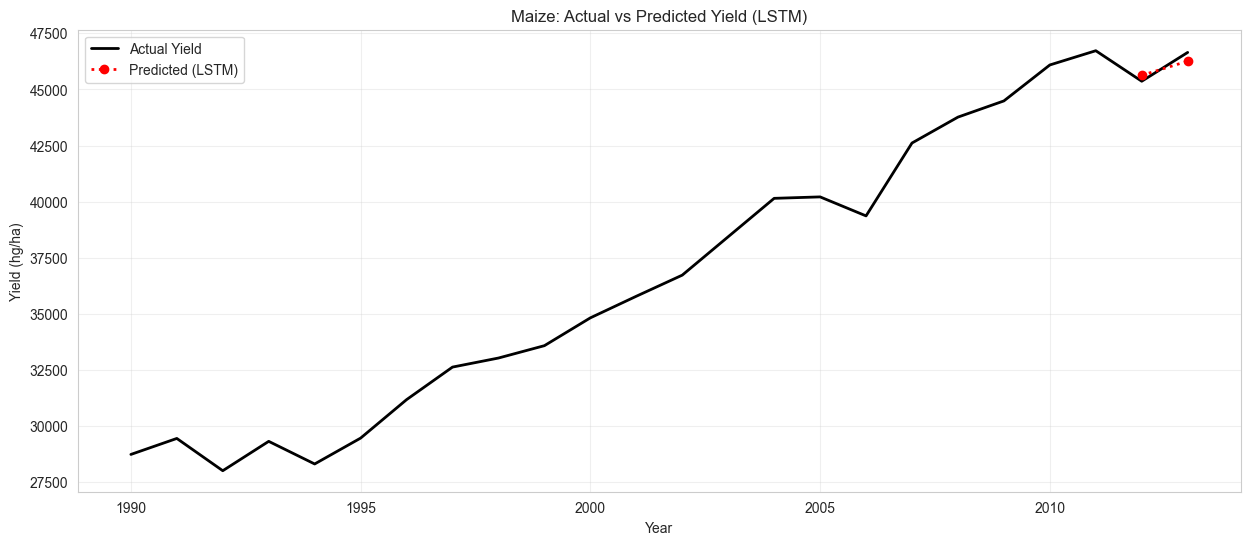

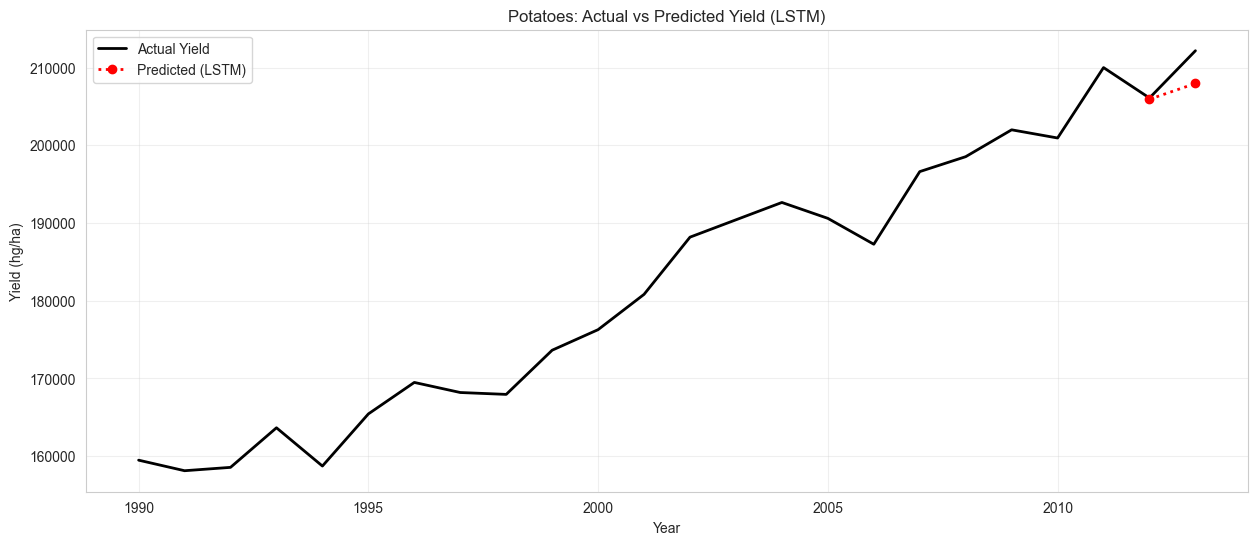

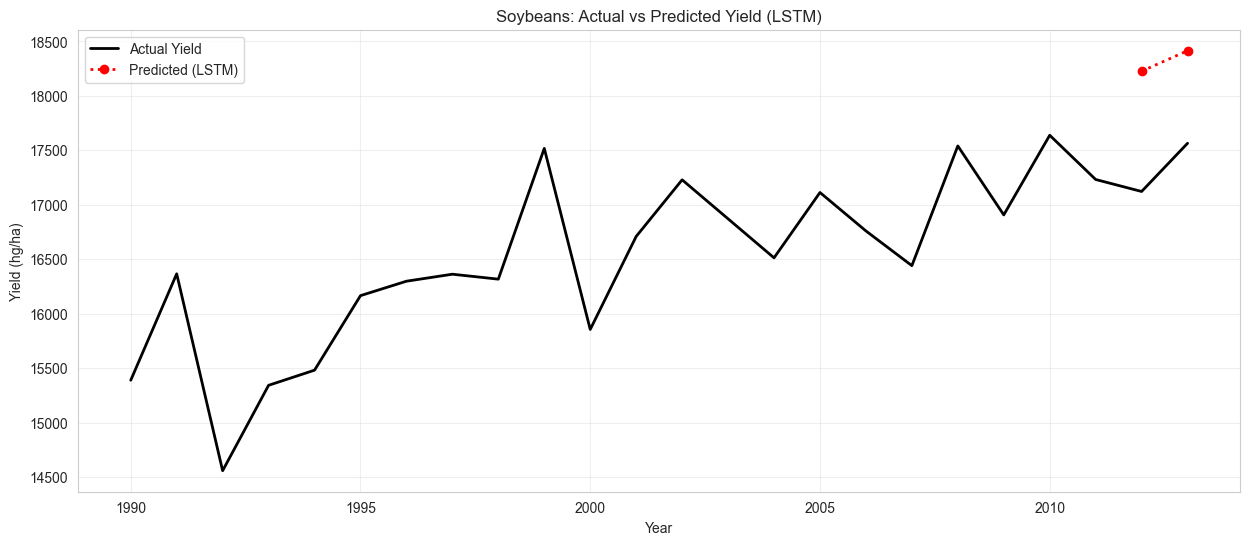

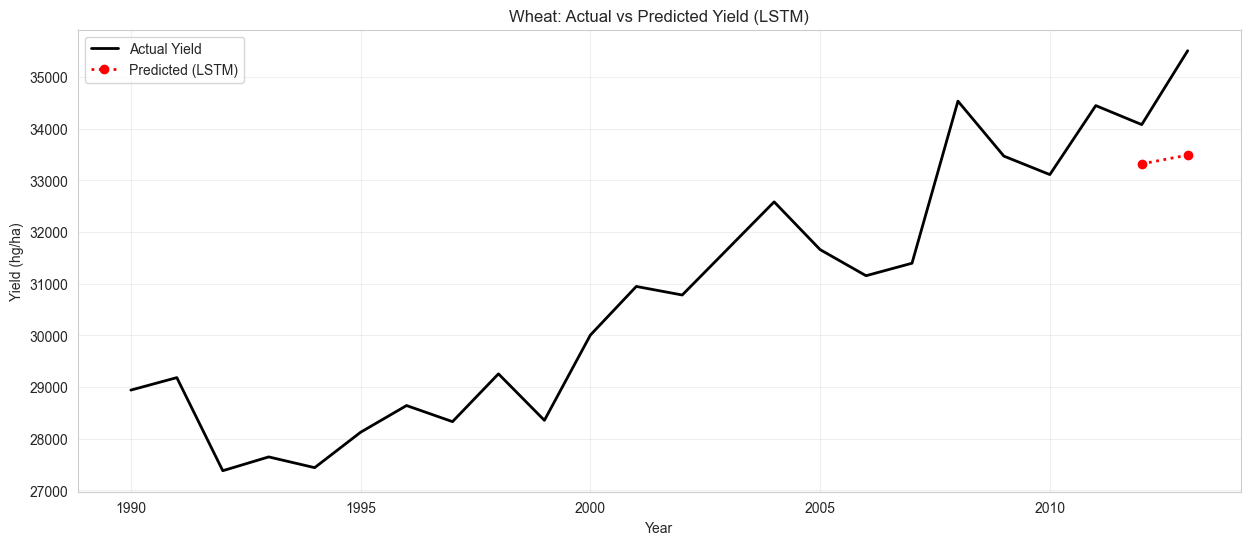

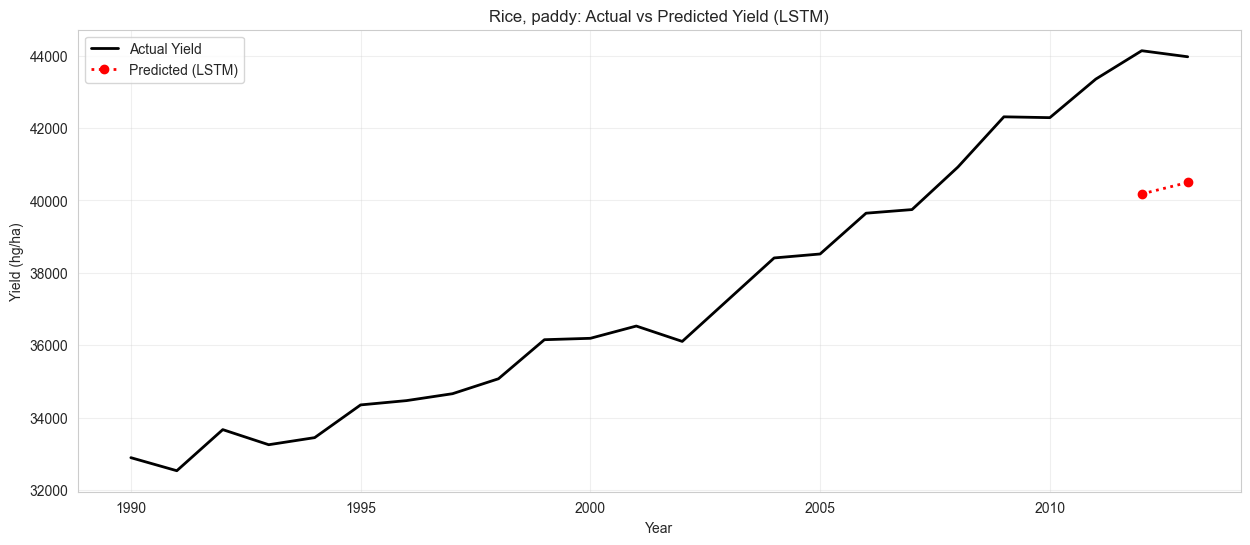

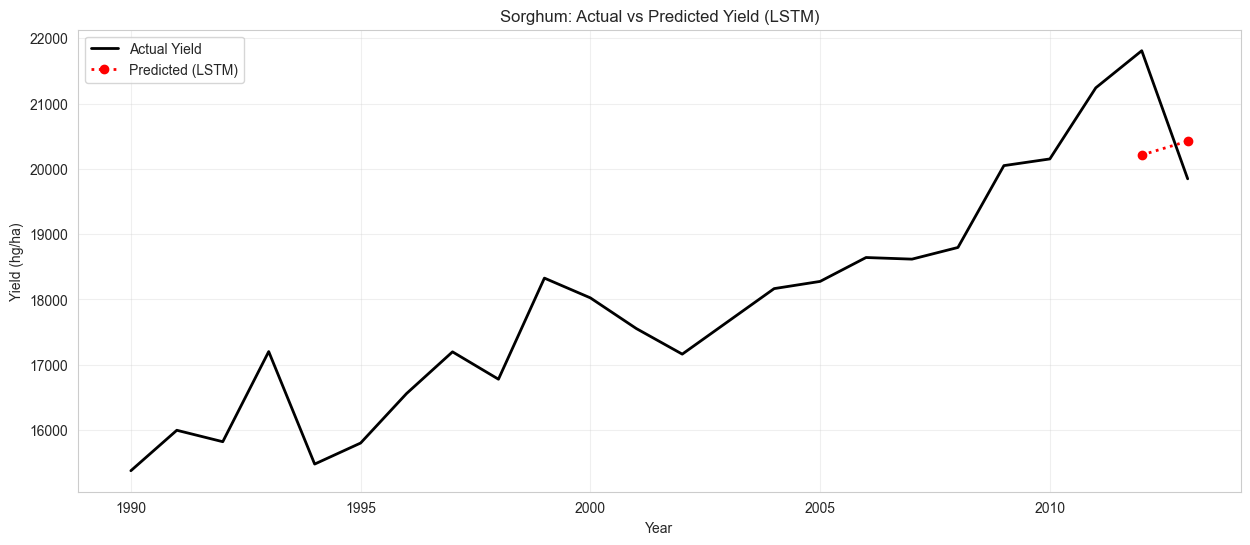

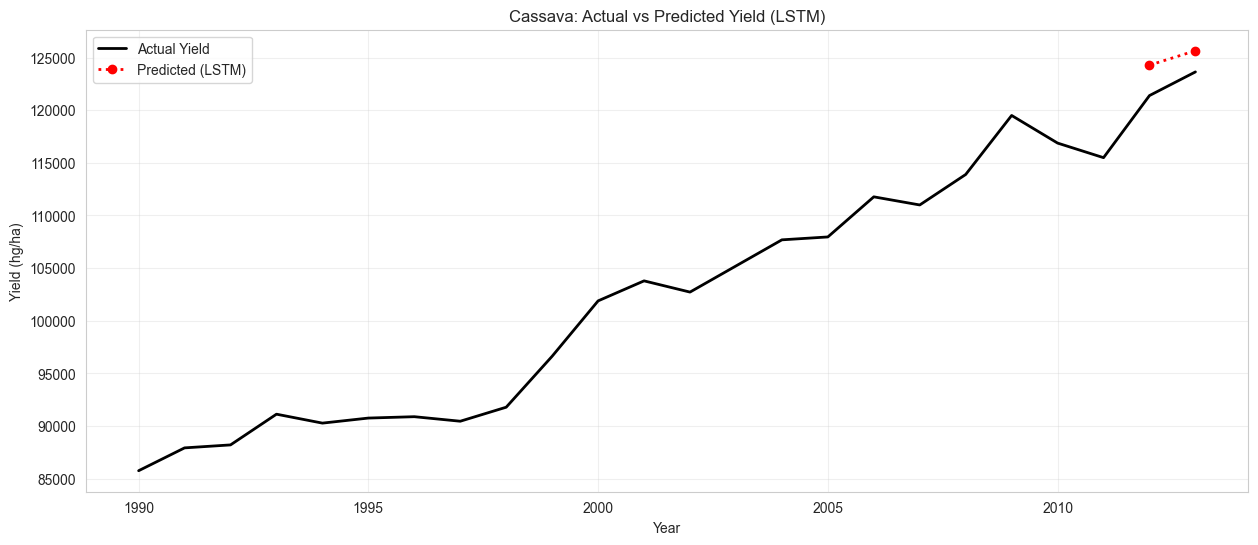

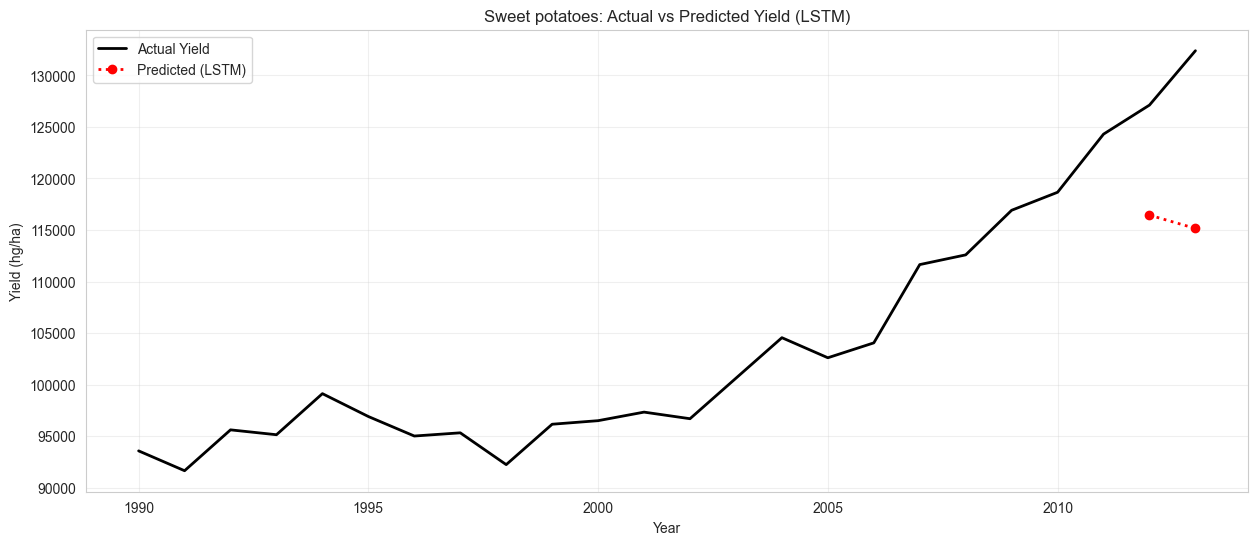

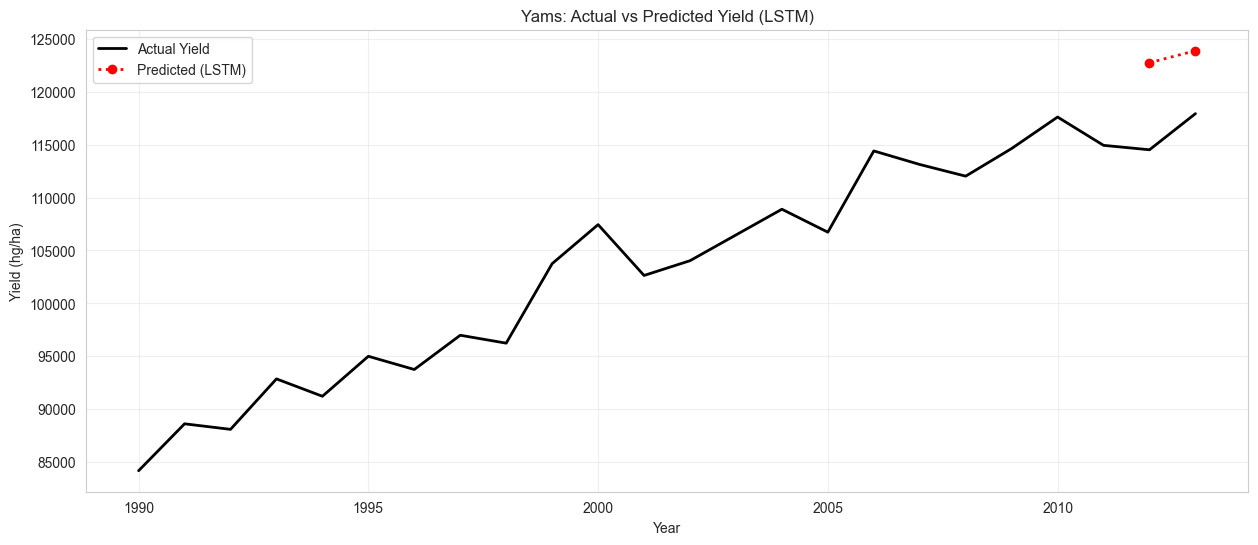

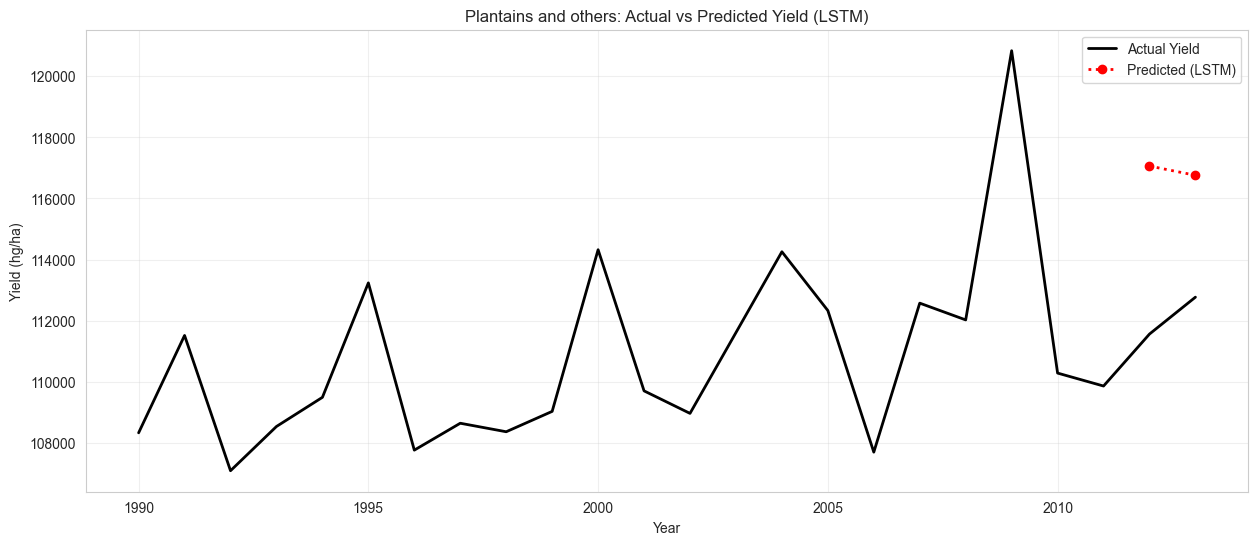

--- Pipeline Complete ---


In [9]:
print("\n--- Step 8: Visualizing Best Model ---")

best_name = df_results.index[0]
best_pred = final_preds[best_name]
print(f"Plotting results for: {best_name}")

# Decide which dataframe to use for plotting (ML vs DL alignment)
plot_df = test_df.copy() if best_name in ['Ridge', 'RF', 'XGB'] else test_df_dl_ref.copy()
plot_df['prediction'] = best_pred

unique_crops = plot_df['Item'].unique()

for crop in unique_crops:
    plt.figure(figsize=(15, 6))
    
    # 1. Get Actual History (Global Average per Year)
    # We use the original df to show the full history line
    history_df = df[df['Item'] == crop]
    history_grp = history_df.groupby('Year')[TARGET].mean()
    
    # 2. Get Predictions (Test Period Only)
    pred_grp = plot_df[plot_df['Item'] == crop].groupby('Year')['prediction'].mean()
    
    if not pred_grp.empty:
        # Plot Actuals (Black Line)
        plt.plot(history_grp.index, history_grp.values, 'k-', lw=2, label='Actual Yield')
        
        # Plot Predictions (Red Dotted)
        plt.plot(pred_grp.index, pred_grp.values, 'r:o', lw=2, label=f'Predicted ({best_name})')
        
        plt.title(f"{crop}: Actual vs Predicted Yield ({best_name})")
        plt.xlabel("Year")
        plt.ylabel("Yield (hg/ha)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

print("--- Pipeline Complete ---")